In [1]:
import os
import rasterio
import numpy as np
from skimage import feature
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


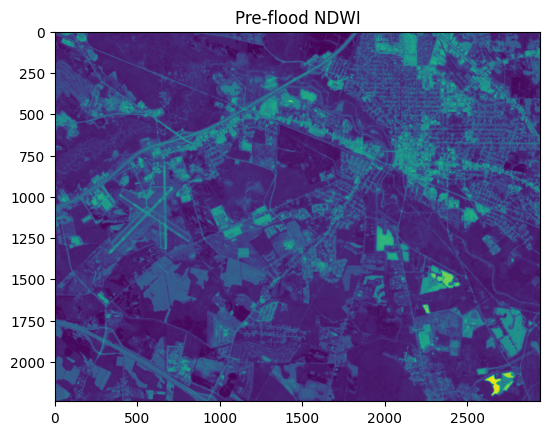

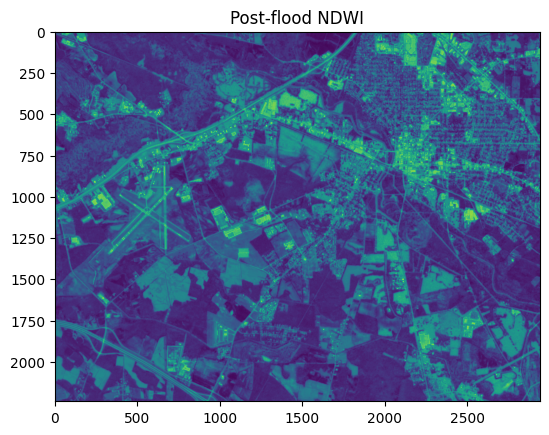

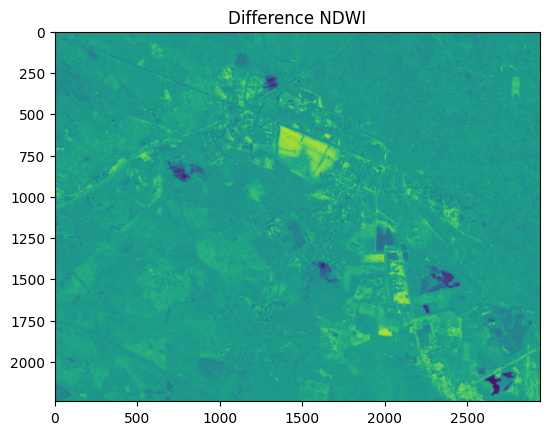

/home/ai4sg/jamp/bitemporalUNet/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


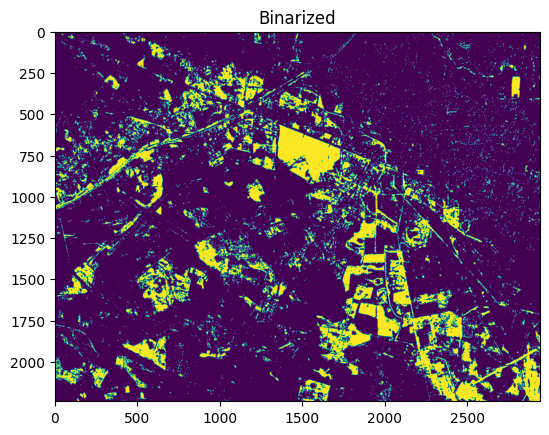

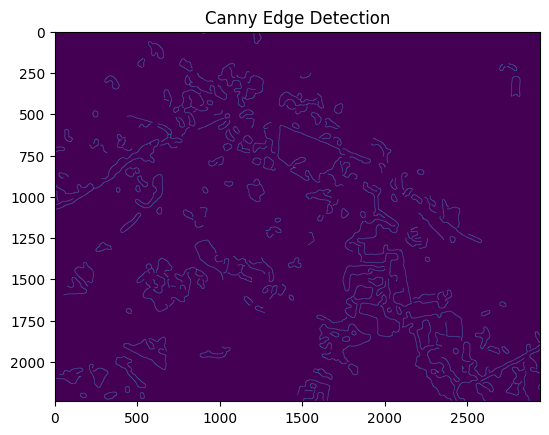

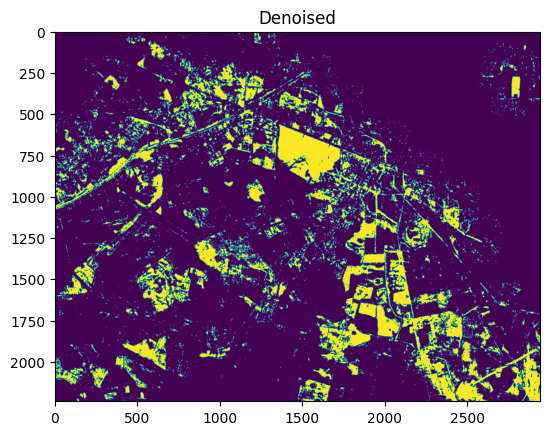

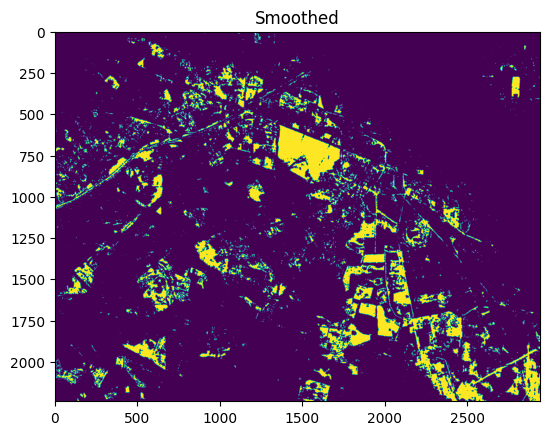

In [2]:
def ndwi(image):
    green = image[1].astype(float)
    nir = image[3].astype(float)
    ndwi = (green - nir) / (green + nir)
    return ndwi

def kmeans_binarize(img):
    img = img.astype('float64')
    X = img.reshape((-1, 1))
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    labels = 1 - kmeans.labels_
    binarized = labels.reshape(img.shape)
    return binarized


def canny(img):
    img = img.astype('float64')
    gauss = ndi.gaussian_filter(img, 7)
    edges = feature.canny(gauss, sigma=7)
    return edges


def denoise(can, ndwi):
    kernel = np.ones((9,9),np.uint8)
    dilation = ndi.binary_dilation(can, kernel, iterations=30)
    both = np.logical_and(ndwi, dilation)
    return both

def gaussian_smooth(image, sigma=0.25):
    return ndi.gaussian_filter(image, sigma)

def flood_detection(pre_flood_path, post_flood_path):
    with rasterio.open(pre_flood_path) as src:
        pre_flood = src.read()

    with rasterio.open(post_flood_path) as src:
        post_flood = src.read()

    pre_ndwi = ndwi(pre_flood)
    post_ndwi = ndwi(post_flood)

    plt.imshow(pre_ndwi)
    plt.title("Pre-flood NDWI")
    plt.show()

    plt.imshow(post_ndwi)
    plt.title("Post-flood NDWI")
    plt.show()

    diff_ndwi = post_ndwi - pre_ndwi
    plt.imshow(diff_ndwi)
    plt.title("Difference NDWI")
    plt.show()

    binarized = kmeans_binarize(diff_ndwi)
    plt.imshow(binarized)
    plt.title("Binarized")
    plt.show()

    canny_image = canny(binarized)
    plt.imshow(canny_image)
    plt.title("Canny Edge Detection")
    plt.show()

    denoised = denoise(canny_image, binarized)
    plt.imshow(denoised)
    plt.title("Denoised")
    plt.show()

    smoothed = gaussian_smooth(denoised)
    plt.imshow(smoothed)
    plt.title("Smoothed")
    plt.show()
    
    return smoothed

def main():
    pre_flood_path = '/home/ai4sg/jamp/bitemporalUNet/data/florence/planet_florence_aoi04012020_08302018.tif'
    post_flood_path = '/home/ai4sg/jamp/bitemporalUNet/data/florence/planet_florence_aoi04012020_09182018.tif'
    result = flood_detection(pre_flood_path, post_flood_path)

    # np.save('/home/ai4sg/jamp/bitemporalUNet/data/florence/florence_wl.npy', result)

if __name__ == "__main__":
    main()



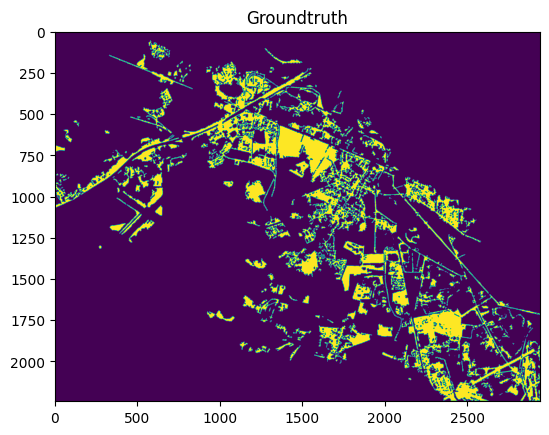

In [3]:
gt = np.load("/home/ai4sg/jamp/myunet/data/florence_final/floodmask.npy")
plt.imshow(gt)
plt.title("Groundtruth")
plt.show()

In [4]:
height, width = gt.shape[0],gt.shape[1]
tsz = 140
n_row = height // tsz
n_col = width // tsz
n_row, n_col

(16, 21)

In [5]:

def crop_tiles(outpath, input_arr):
    for r in range(n_row):
        for c in range(n_col):
            tile = input_arr[r*tsz:(r+1)*tsz, c*tsz:(c+1)*tsz]
            num_r = str(r).zfill(2)
            num_c = str(c).zfill(2)
            np.save(os.path.join('outpath', 'florence_{}_{}.npy'.format(num_r,num_c)), tile)
            